<a href="https://colab.research.google.com/github/Himika-Mishra/Dissertation/blob/main/Mnist_Random_Noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from skimage.util import random_noise
from tqdm import tqdm
import random
from sklearn.preprocessing import OneHotEncoder
import scipy.sparse as sp

In [ ]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [ ]:
# Flatten the images and normalize the pixel values to [0, 1]
x_train = x_train.reshape((60000, 28 * 28)).astype('float32') / 255
x_test = x_test.reshape((10000, 28 * 28)).astype('float32') / 255

In [ ]:
# Create an instance of OneHotEncoder
encoder = OneHotEncoder()

# Fit the encoder on train_labels
encoder.fit(y_train.reshape(-1, 1))

# Encode the train labels
y_train = encoder.transform(y_train.reshape(-1, 1))
# Convert the csr_matrix to a numpy.ndarray
y_train = y_train.toarray()

# Encode the test labels
y_test = encoder.transform(y_test.reshape(-1, 1))
# Convert the csr_matrix to a numpy.ndarray
y_test = y_test.toarray()

In [ ]:
type(y_test)

numpy.ndarray

In [ ]:
x_train.shape

(60000, 784)

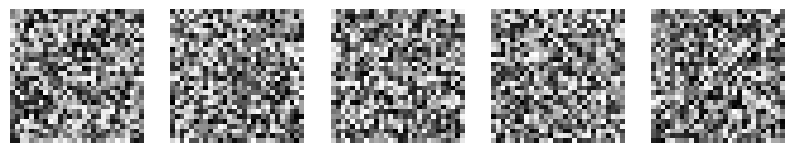

In [ ]:
# Generate random noise images
noise_images = np.random.uniform(low=0.0, high=1.0, size=(1000000, 784))

# Plot random 5 noise images
random_indices = np.random.choice(len(noise_images), size=5, replace=False)

fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i, index in enumerate(random_indices):
    noise_image = noise_images[index].reshape(28, 28)
    axes[i].imshow(noise_image, cmap='gray')
    axes[i].axis('off')

plt.show()

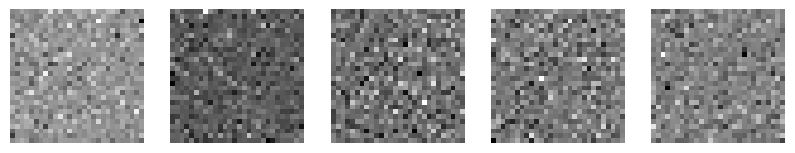

In [ ]:
# Generate random noise images
noise_images = np.random.laplace(loc=0.5, scale=0.1, size=(1000000, 784))

# Plot random 5 noise images
random_indices = np.random.choice(len(noise_images), size=5, replace=False)

fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i, index in enumerate(random_indices):
    noise_image = noise_images[index].reshape(28, 28)
    axes[i].imshow(noise_image, cmap='gray')
    axes[i].axis('off')

plt.show()


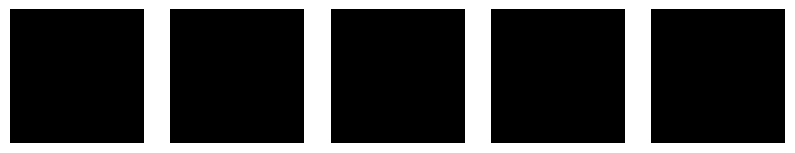

In [ ]:
# Define the parameters for random Fourier function
num_components = 100
amplitude_range = (0, 1)
phase_range = (0, 2*np.pi)

# Generate random noise images
noise_images = np.zeros((1000000, 784))

for i in range(num_components):
    amplitude = np.random.uniform(*amplitude_range)
    phase = np.random.uniform(*phase_range)

    random_fourier = np.random.normal(0, 1, size=(1000000, 2))
    random_fourier *= amplitude
    random_fourier = np.cos(random_fourier)
    random_fourier = np.sum(random_fourier, axis=1)
    random_fourier *= np.sqrt(2 / num_components)
    random_fourier *= np.sqrt(1 / 2)

    noise_images += random_fourier.reshape(-1, 1)

# Plot random 5 noise images
random_indices = np.random.choice(len(noise_images), size=5, replace=False)

fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i, index in enumerate(random_indices):
    noise_image = noise_images[index].reshape(28, 28)
    axes[i].imshow(noise_image, cmap='gray')
    axes[i].axis('off')

plt.show()

In [ ]:
# Create a dataframe to store the noisy images
x_train_distorted = pd.DataFrame(noise_images)

In [ ]:
len(x_train_distorted)

1000000

In [ ]:
# Create a dataframe of array of zeroes as labels for above distorted images
y_train_distorted = np.zeros((1000000, 10))

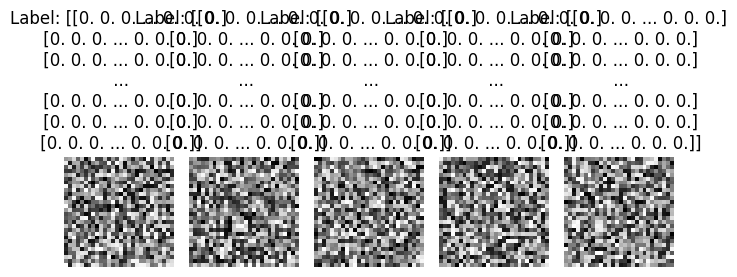

In [ ]:
# Select 5 random indices
random_indices = random.sample(range(len(x_train_distorted)), 5)

# Retrieve the distorted images and labels at the selected indices
distorted_images = [noise_images[i] for i in random_indices]
labels = [y_train_distorted for i in random_indices]

# Display the distorted images
for i in range(5):
    image = distorted_images[i]
    label = labels[i]
    
    # Reshape the image back to its original shape (assuming it was flattened)
    image = image.reshape(28, 28)
    
    # Plot the image
    plt.subplot(1, 5, i+1)
    plt.imshow(image, cmap='gray')
    plt.title(f'Label: {label}')
    plt.axis('off')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

In [ ]:
# Initialize the merged train dataframe
merged_x_train = pd.DataFrame()

In [ ]:
# Define the ratio of distorted images to select
ratios = np.arange(0.1, 1.1, 0.1)

In [ ]:
# Convert the distorted train data from list and ndarray to DataFrame
x_train = pd.DataFrame(x_train)
y_train = pd.DataFrame(y_train)
x_train_distorted = pd.DataFrame(x_train_distorted)
y_train_distorted = pd.DataFrame(y_train_distorted)

In [ ]:
# Iterate over the ratios
for ratio in ratios:
    # Calculate the number of distorted images to select based on the ratio
    num_distorted = int(len(x_train) * ratio)

    # Randomly select the specified number of distorted images
    selected_distorted_images = x_train_distorted.sample(n=num_distorted, random_state=42)
    selected_distorted_labels = y_train_distorted.sample(n=num_distorted, random_state=42)

    # Concatenate the selected distorted images with the original train dataframe
    merged_x_train = pd.concat([x_train, selected_distorted_images])
    merged_y_train = pd.concat([y_train, selected_distorted_labels])

    # Train and evaluate the model 
    # Fit a regular MLP classifier
    mlp = MLPClassifier(hidden_layer_sizes=(10,8), activation='relu', solver='adam', max_iter=500)
    mlp.fit(merged_x_train, merged_y_train)
    # Accuracy Score
    test_acc = mlp.score(merged_x_train, merged_y_train)
    # print(mlp.score(merged_x_train, merged_y_train))
    print(f"Test accuracy with original_ratio={ratio}: {test_acc}")

    # predictions
    pred = mlp.predict(x_test)
    print(confusion_matrix(y_test.argmax(axis=1), pred.argmax(axis=1)))
    print(classification_report(y_test.argmax(axis=1), pred.argmax(axis=1)))
    print("--------------------------------------------------")

Test accuracy with original_ratio=0.1: 0.9408484848484848
[[ 966    0    0    1    1    0    7    2    1    2]
 [  14 1107    6    0    0    1    1    1    5    0]
 [  46    6  937   12    5    0    9   10    7    0]
 [  51    3   13  922    1    5    0    4    9    2]
 [  26    0    5    2  920    0    9    2    2   16]
 [  55    3    1   24    2  779    8    3   11    6]
 [  44    2    2    0    6   18  881    0    5    0]
 [  37    7   20    7    3    0    0  939    4   11]
 [  60    9    4   21   13   14    3    1  846    3]
 [  54    5    0   12   31    4    0    5    9  889]]
              precision    recall  f1-score   support

           0       0.71      0.99      0.83       980
           1       0.97      0.98      0.97      1135
           2       0.95      0.91      0.93      1032
           3       0.92      0.91      0.92      1010
           4       0.94      0.94      0.94       982
           5       0.95      0.87      0.91       892
           6       0.96      0.9